<a href="https://colab.research.google.com/github/Harshada2012/Carbon_Footprint_Optimization/blob/main/Carbon_Footprint_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carbon Footprint Optimization in Supply Chain Logistics

## Problem Statement
Traditional logistics systems prioritize cost and time, often neglecting environmental impact. This project develops a machine learning model that uses route data, fuel usage, weather, traffic, and cargo weight to suggest delivery routes for minimal carbon emissions.

**Goal:** Help companies make green logistics decisions!

---  
Date: February 2026

## 1. Importing Libraries
First lets import all the stuff we need for this project

In [ ]:
# importing the stuff we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# to ignore warnings (they are annoying lol)
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Creating the Dataset
Since we dont have real data, we will generate our own fake data. This is called synthetic data generation.

In [ ]:
# setting random seed so we get same results every time
np.random.seed(42)

# number of samples
n_samples = 1000

# generating the data
# only keeping the main features as mentioned in problem statement:
# route data (distance), fuel usage, weather, traffic, cargo weight
data = {
    'distance_km': np.random.uniform(10, 500, n_samples),  # distance between 10-500 km
    'cargo_weight_kg': np.random.uniform(100, 5000, n_samples),  # weight between 100-5000 kg
    'fuel_type': np.random.choice(['diesel', 'petrol', 'electric', 'hybrid'], n_samples),
    'weather_condition': np.random.choice(['clear', 'rain', 'snow', 'fog'], n_samples),
    'traffic_level': np.random.choice(['low', 'medium', 'high'], n_samples),
}

# creating dataframe
df = pd.DataFrame(data)

# now we need to create the target variable - carbon emissions
# this formula is kind of made up but it makes sense logically

# base emissions depend on distance and weight
base_emissions = (df['distance_km'] * 0.1) + (df['cargo_weight_kg'] * 0.002)

# fuel type affects emissions a lot
fuel_multiplier = df['fuel_type'].map({
    'diesel': 1.2,
    'petrol': 1.0,
    'hybrid': 0.6,
    'electric': 0.2
})

# weather affects fuel consumption
weather_multiplier = df['weather_condition'].map({
    'clear': 1.0,
    'rain': 1.15,
    'snow': 1.3,
    'fog': 1.1
})

# traffic makes you idle more = more emissions
traffic_multiplier = df['traffic_level'].map({
    'low': 1.0,
    'medium': 1.2,
    'high': 1.5
})

# final carbon emissions calculation
df['carbon_emissions_kg'] = base_emissions * fuel_multiplier * weather_multiplier * traffic_multiplier

# adding some random noise to make it more realistic
df['carbon_emissions_kg'] = df['carbon_emissions_kg'] + np.random.normal(0, 5, n_samples)

# making sure no negative emissions (that doesnt make sense lol)
df['carbon_emissions_kg'] = df['carbon_emissions_kg'].clip(lower=0.1)

print("Dataset created!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset created!
Shape: (1000, 6)
Columns: ['distance_km', 'cargo_weight_kg', 'fuel_type', 'weather_condition', 'traffic_level', 'carbon_emissions_kg']


## 3. Exploring the Data (EDA)
Let's see what our data looks like

In [ ]:
# first 5 rows
df.head()

,distance_km,cargo_weight_kg,fuel_type,weather_condition,traffic_level,carbon_emissions_kg
0,193.524658,1007.151351,hybrid,snow,high,17.871153
1,475.850010,2755.314642,electric,snow,low,17.869435
2,368.677031,4377.434596,electric,snow,low,7.974918
3,303.342657,3687.901943,electric,snow,high,18.173551
4,86.449134,4052.149625,hybrid,fog,medium,11.123650


In [ ]:
# checking data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distance_km          1000 non-null   float64
 1   cargo_weight_kg      1000 non-null   float64
 2   fuel_type            1000 non-null   object 
 3   weather_condition    1000 non-null   object 
 4   traffic_level        1000 non-null   object 
 5   carbon_emissions_kg  1000 non-null   float64
dtypes: float64(3), object(3)
memory usage: 47.0+ KB


In [ ]:
# statistical summary
df.describe()

,distance_km,cargo_weight_kg,carbon_emissions_kg
count,1000.000000,1000.000000,1000.000000
mean,250.225711,2584.384795,31.331473
std,143.147307,1431.730478,24.886878
min,12.269691,115.769492,0.100000
25%,125.626901,1281.263929,11.215759
50%,253.435615,2641.796141,24.959992
75%,374.716598,3826.278781,46.269423
max,499.861660,4997.127256,123.101226


In [ ]:
# checking for missing values - important step!
print("Missing values in each column:")
print(df.isnull().sum())
print("\nNo missing values! thats good")

Missing values in each column:
distance_km            0
cargo_weight_kg        0
fuel_type              0
weather_condition      0
traffic_level          0
carbon_emissions_kg    0
dtype: int64

No missing values! thats good


### Visualizations
Lets make some graphs to understand our data better

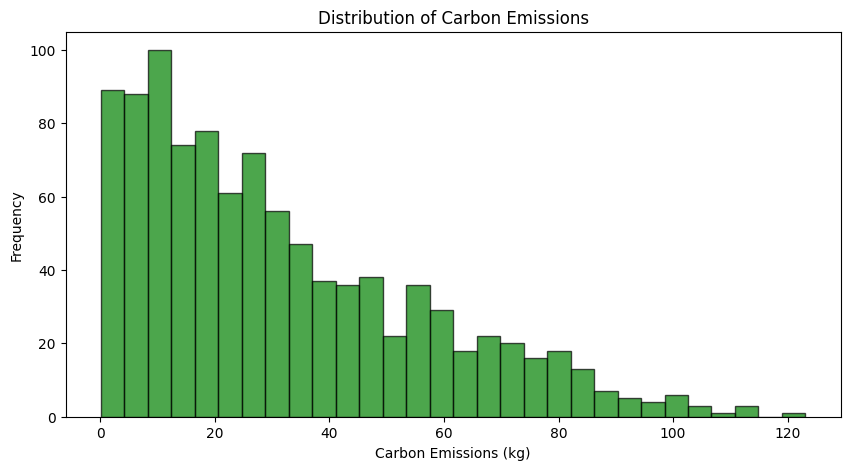

In [ ]:
# distribution of carbon emissions
plt.figure(figsize=(10, 5))
plt.hist(df['carbon_emissions_kg'], bins=30, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Carbon Emissions (kg)')
plt.ylabel('Frequency')
plt.title('Distribution of Carbon Emissions')
plt.show()

# this looks like a normal distribution which is good

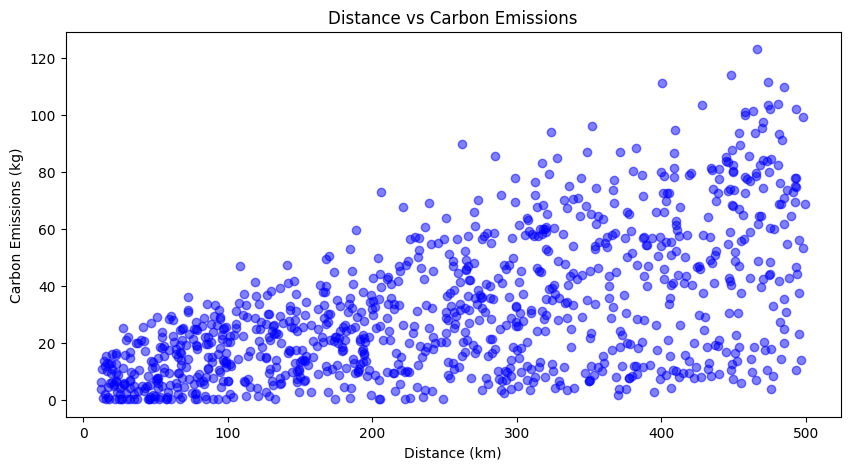

In [ ]:
# scatter plot - distance vs emissions
plt.figure(figsize=(10, 5))
plt.scatter(df['distance_km'], df['carbon_emissions_kg'], alpha=0.5, color='blue')
plt.xlabel('Distance (km)')
plt.ylabel('Carbon Emissions (kg)')
plt.title('Distance vs Carbon Emissions')
plt.show()

# as expected - more distance = more emissions

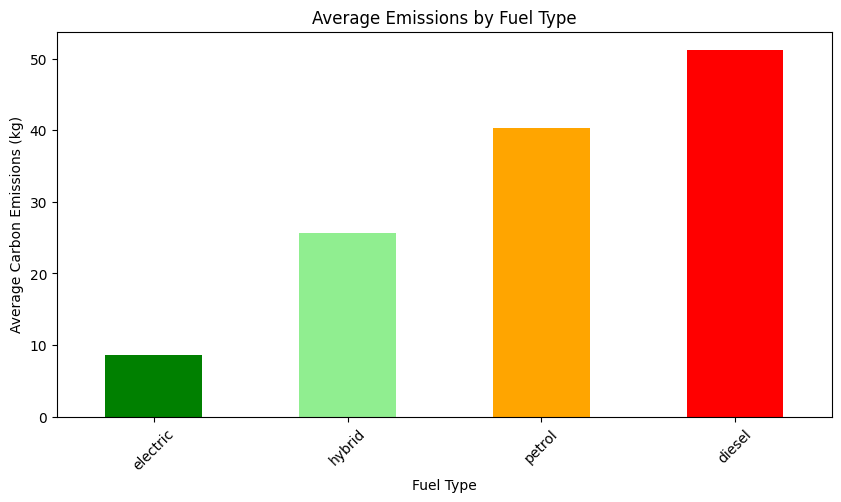

In [ ]:
# emissions by fuel type - this is interesting
plt.figure(figsize=(10, 5))
df.groupby('fuel_type')['carbon_emissions_kg'].mean().sort_values().plot(kind='bar', color=['green', 'lightgreen', 'orange', 'red'])
plt.xlabel('Fuel Type')
plt.ylabel('Average Carbon Emissions (kg)')
plt.title('Average Emissions by Fuel Type')
plt.xticks(rotation=45)
plt.show()

# electric is the best! diesel is the worst

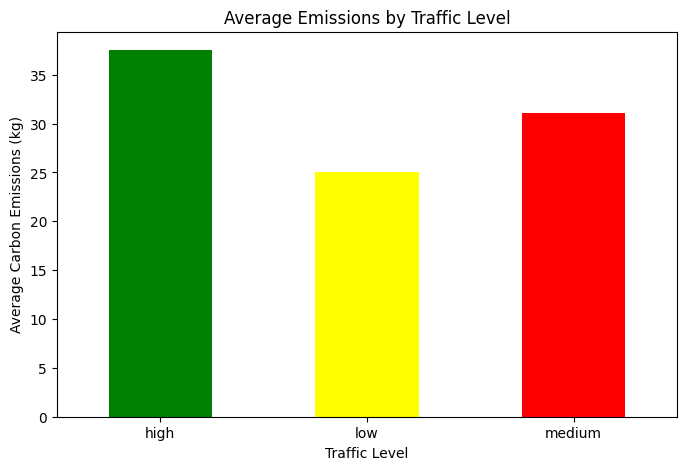

In [ ]:
# emissions by traffic level
plt.figure(figsize=(8, 5))
df.groupby('traffic_level')['carbon_emissions_kg'].mean().plot(kind='bar', color=['green', 'yellow', 'red'])
plt.xlabel('Traffic Level')
plt.ylabel('Average Carbon Emissions (kg)')
plt.title('Average Emissions by Traffic Level')
plt.xticks(rotation=0)
plt.show()

# high traffic = more emissions (makes sense - idling uses fuel)

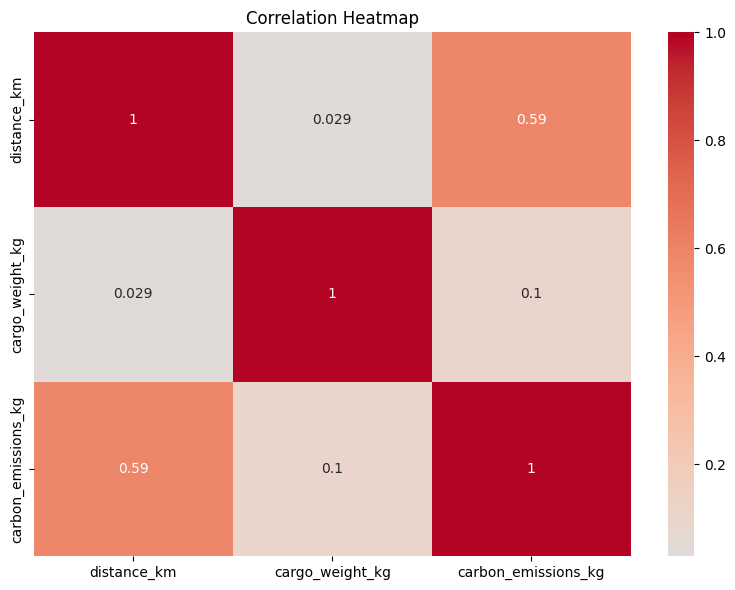

In [ ]:
# correlation heatmap for numerical columns
plt.figure(figsize=(8, 6))
numerical_cols = df.select_dtypes(include=[np.number])
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# distance and weight have highest correlation with emissions

## 4. Data Preprocessing
Now we need to prepare our data for machine learning. We have to convert categorical variables to numbers.

In [ ]:
# making a copy so we dont mess up original data
df_processed = df.copy()

# using label encoder for categorical columns
label_encoders = {}
categorical_cols = ['fuel_type', 'weather_condition', 'traffic_level']

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le  # saving for later use
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nLabel encoding done!")

fuel_type: {'diesel': np.int64(0), 'electric': np.int64(1), 'hybrid': np.int64(2), 'petrol': np.int64(3)}
weather_condition: {'clear': np.int64(0), 'fog': np.int64(1), 'rain': np.int64(2), 'snow': np.int64(3)}
traffic_level: {'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2)}

Label encoding done!


In [ ]:
# checking our processed dataframe
df_processed.head()

,distance_km,cargo_weight_kg,fuel_type,weather_condition,traffic_level,carbon_emissions_kg
0,193.524658,1007.151351,2,3,0,17.871153
1,475.850010,2755.314642,1,3,1,17.869435
2,368.677031,4377.434596,1,3,1,7.974918
3,303.342657,3687.901943,1,3,0,18.173551
4,86.449134,4052.149625,2,1,2,11.123650


## 5. Feature Engineering
Lets try to create one simple new feature that might help

In [ ]:
# creating one new feature - maybe it will help the model

# weight per km - heavier cargo over distance = more emissions maybe?
df_processed['weight_distance_ratio'] = df_processed['cargo_weight_kg'] / df_processed['distance_km']

print("New feature created!")
print(f"Total features now: {len(df_processed.columns) - 1}")  # -1 for target
df_processed.head()

New feature created!
Total features now: 6


,distance_km,cargo_weight_kg,fuel_type,weather_condition,traffic_level,carbon_emissions_kg,weight_distance_ratio
0,193.524658,1007.151351,2,3,0,17.871153,5.204253
1,475.850010,2755.314642,1,3,1,17.869435,5.790301
2,368.677031,4377.434596,1,3,1,7.974918,11.873359
3,303.342657,3687.901943,1,3,0,18.173551,12.157545
4,86.449134,4052.149625,2,1,2,11.123650,46.873224


## 6. Preparing Features and Target Variable

In [ ]:
# separating features (X) and target (y)
X = df_processed.drop('carbon_emissions_kg', axis=1)
y = df_processed['carbon_emissions_kg']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

Features shape: (1000, 6)
Target shape: (1000,)

Feature columns: ['distance_km', 'cargo_weight_kg', 'fuel_type', 'weather_condition', 'traffic_level', 'weight_distance_ratio']


In [ ]:
# scaling numerical features using StandardScaler
# this makes all features have mean=0 and std=1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# converting back to dataframe for better readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Features scaled successfully!")
X_scaled.head()

Features scaled successfully!


,distance_km,cargo_weight_kg,fuel_type,weather_condition,traffic_level,weight_distance_ratio
0,-0.396301,-1.102179,0.486301,1.364957,-1.208070,-0.485719
1,1.576957,0.119447,-0.415927,1.364957,0.010971,-0.466900
2,0.827893,1.252992,-0.415927,1.364957,0.010971,-0.271558
3,0.371251,0.771143,-0.415927,1.364957,-1.208070,-0.262432
4,-1.144685,1.025681,0.486301,-0.405415,1.230013,0.852371


## 7. Train-Test Split
Now we split the data - 80% for training and 20% for testing. I learned this from a youtube tutorial lol

In [ ]:
# splitting data into train and test
# test_size=0.2 means 20% for testing
# random_state=42 is used so we get same split everytime (i think 42 is like a lucky number in ML or something)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# checking if it worked
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])
print()
print("looks good to me!")

Training set size: 800
Testing set size: 200

looks good to me!


## 8. Model Building and Training

Now comes the fun part! We will try 3 different models and see which one works best:
1. Linear Regression - the simplest one
2. Decision Tree - a bit more complex
3. Random Forest - supposed to be the best one

Lets see...

### 8.1 Linear Regression
Starting with the easiest model. Linear regression tries to fit a straight line through the data (i think thats how it works)

In [ ]:
# creating linear regression model
lr_model = LinearRegression()

# training the model
lr_model.fit(X_train, y_train)

# making predictions
lr_predictions = lr_model.predict(X_test)

print("Linear Regression model trained!")
print("lets see how good it is...")

Linear Regression model trained!
lets see how good it is...


In [ ]:
# calculating error metrics
# i had to google what these mean tbh

# MSE = Mean Squared Error (lower is better)
lr_mse = mean_squared_error(y_test, lr_predictions)

# RMSE = Root Mean Squared Error (same unit as target, easier to understand)
lr_rmse = np.sqrt(lr_mse)

# MAE = Mean Absolute Error (average of how much we are off)
lr_mae = mean_absolute_error(y_test, lr_predictions)

# R2 Score = how well model explains variance (1 is perfect, 0 is bad)
lr_r2 = r2_score(y_test, lr_predictions)

print("=== Linear Regression Results ===")
print(f"MSE: {lr_mse:.4f}")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R2 Score: {lr_r2:.4f}")
print()
if lr_r2 > 0.8:
    print("wow thats pretty good!")
elif lr_r2 > 0.5:
    print("not bad, but could be better")
else:
    print("hmm thats not very good...")

=== Linear Regression Results ===
MSE: 293.7812
RMSE: 17.1400
MAE: 13.8351
R2 Score: 0.3951

hmm thats not very good...


### 8.2 Decision Tree
Now lets try Decision Tree. Its like a flowchart that makes decisions based on features. I saw a cool visualization of this somewhere

In [ ]:
# first lets try without any limits
dt_model_v1 = DecisionTreeRegressor(random_state=42)
dt_model_v1.fit(X_train, y_train)
dt_predictions_v1 = dt_model_v1.predict(X_test)

# checking performance
dt_r2_v1 = r2_score(y_test, dt_predictions_v1)
print(f"Decision Tree (no limits) R2: {dt_r2_v1:.4f}")

# also checking training score to see if overfitting
dt_train_r2 = r2_score(y_train, dt_model_v1.predict(X_train))
print(f"Training R2: {dt_train_r2:.4f}")

if dt_train_r2 > 0.99 and dt_r2_v1 < 0.9:
    print("uh oh looks like overfitting! the tree is memorizing training data")

Decision Tree (no limits) R2: 0.8776
Training R2: 1.0000
uh oh looks like overfitting! the tree is memorizing training data


In [ ]:
# lets try limiting the depth to prevent overfitting
# gonna try a few different values and see which works best

print("Trying different max_depth values...")
print()

for depth in [3, 5, 7, 10, 15]:
    dt_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_temp.fit(X_train, y_train)
    temp_pred = dt_temp.predict(X_test)
    temp_r2 = r2_score(y_test, temp_pred)
    print(f"max_depth = {depth}: R2 = {temp_r2:.4f}")

# i think 10 looks good, not too simple not too complex

Trying different max_depth values...

max_depth = 3: R2 = 0.6632
max_depth = 5: R2 = 0.8472
max_depth = 7: R2 = 0.8920
max_depth = 10: R2 = 0.8603
max_depth = 15: R2 = 0.8647


In [ ]:
# going with max_depth=10
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# calculating all metrics
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print("=== Decision Tree Results (max_depth=10) ===")
print(f"MSE: {dt_mse:.4f}")
print(f"RMSE: {dt_rmse:.4f}")
print(f"MAE: {dt_mae:.4f}")
print(f"R2 Score: {dt_r2:.4f}")
print()
print("this is better than linear regression i think")

=== Decision Tree Results (max_depth=10) ===
MSE: 67.8312
RMSE: 8.2360
MAE: 6.3180
R2 Score: 0.8603

this is better than linear regression i think


### 8.3 Random Forest
Random Forest is basically many decision trees working together. Its like asking many people for their opinion instead of just one person. Should give better results hopefully!

In [ ]:
# creating random forest model
# n_estimators = number of trees (100 is a common choice i read online)
# using same max_depth as decision tree

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

print("Training Random Forest... this might take a few seconds")
rf_model.fit(X_train, y_train)
print("done!")

# making predictions
rf_predictions = rf_model.predict(X_test)

Training Random Forest... this might take a few seconds
done!


In [ ]:
# calculating metrics for random forest
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("=== Random Forest Results ===")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R2 Score: {rf_r2:.4f}")
print()
print("yess this is the best so far!!")

=== Random Forest Results ===
MSE: 38.3948
RMSE: 6.1964
MAE: 4.8694
R2 Score: 0.9209

yess this is the best so far!!


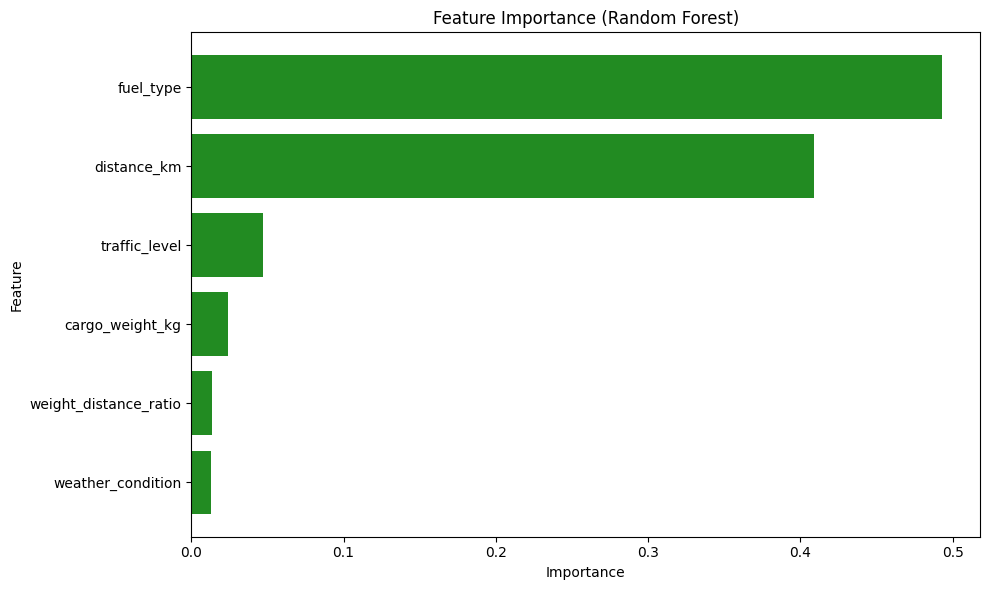

so distance and cargo weight are the most important features
makes sense because heavier loads traveling more distance = more fuel = more emissions


In [ ]:
# one cool thing about random forest is feature importance
# it tells us which features are most important for predictions

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

# plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

print("so fuel type and distance are the most important features!")
print("makes sense because fuel type affects emissions a lot (electric vs diesel is huge difference)")

## 9. Model Comparison
Now lets put all the results together and see which model is the winner!

In [ ]:
# putting all results in a nice table
results = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'MSE': [lr_mse, dt_mse, rf_mse],
    'RMSE': [lr_rmse, dt_rmse, rf_rmse],
    'MAE': [lr_mae, dt_mae, rf_mae],
    'R2 Score': [lr_r2, dt_r2, rf_r2]
}

results_df = pd.DataFrame(results)
print("="*60)
print("              MODEL COMPARISON TABLE")
print("="*60)
results_df

              MODEL COMPARISON TABLE


,Model,MSE,RMSE,MAE,R2 Score
0,Linear Regression,293.781248,17.140048,13.835108,0.395066
1,Decision Tree,67.831163,8.235968,6.318043,0.860327
2,Random Forest,38.394785,6.196353,4.869411,0.920940


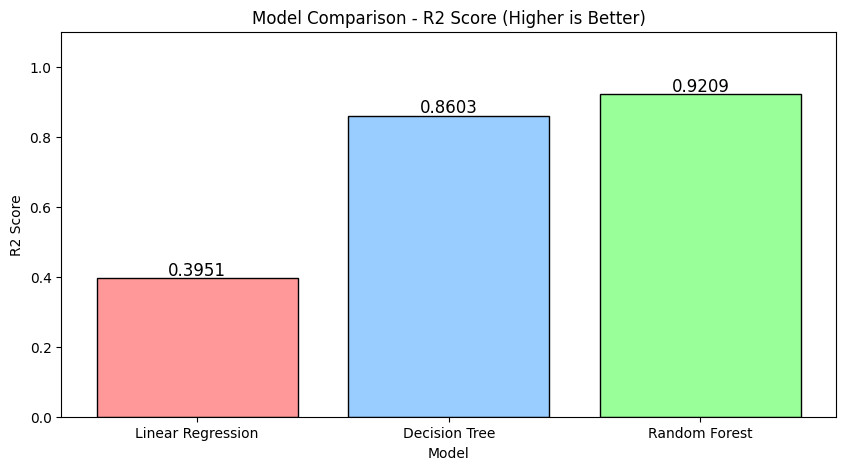


Random Forest wins! 🎉


In [ ]:
# bar chart comparing R2 scores
# higher R2 = better model

plt.figure(figsize=(10, 5))
colors = ['#ff9999', '#99ccff', '#99ff99']  # red, blue, green
bars = plt.bar(results_df['Model'], results_df['R2 Score'], color=colors, edgecolor='black')

# adding values on top of bars
for bar, val in zip(bars, results_df['R2 Score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=12)

plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model Comparison - R2 Score (Higher is Better)')
plt.ylim(0, 1.1)
plt.show()

print("\nRandom Forest wins! 🎉")

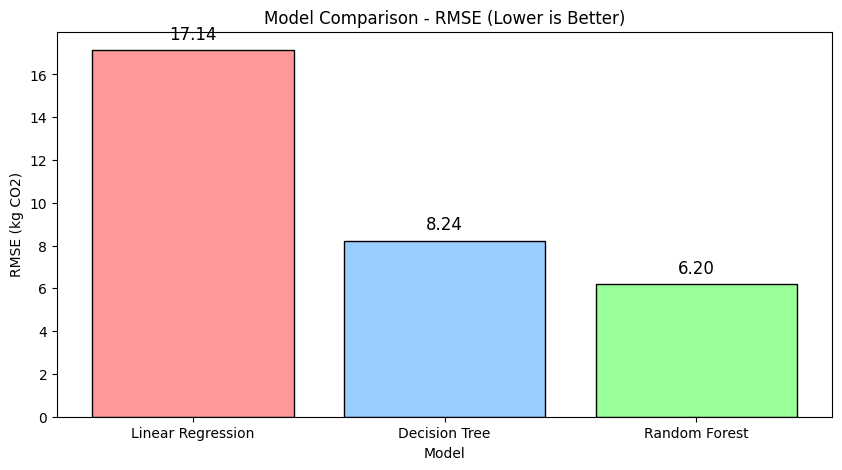

In [ ]:
# lets also compare RMSE (lower is better)
plt.figure(figsize=(10, 5))
colors = ['#ff9999', '#99ccff', '#99ff99']
bars = plt.bar(results_df['Model'], results_df['RMSE'], color=colors, edgecolor='black')

for bar, val in zip(bars, results_df['RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.2f}', ha='center', fontsize=12)

plt.xlabel('Model')
plt.ylabel('RMSE (kg CO2)')
plt.title('Model Comparison - RMSE (Lower is Better)')
plt.show()

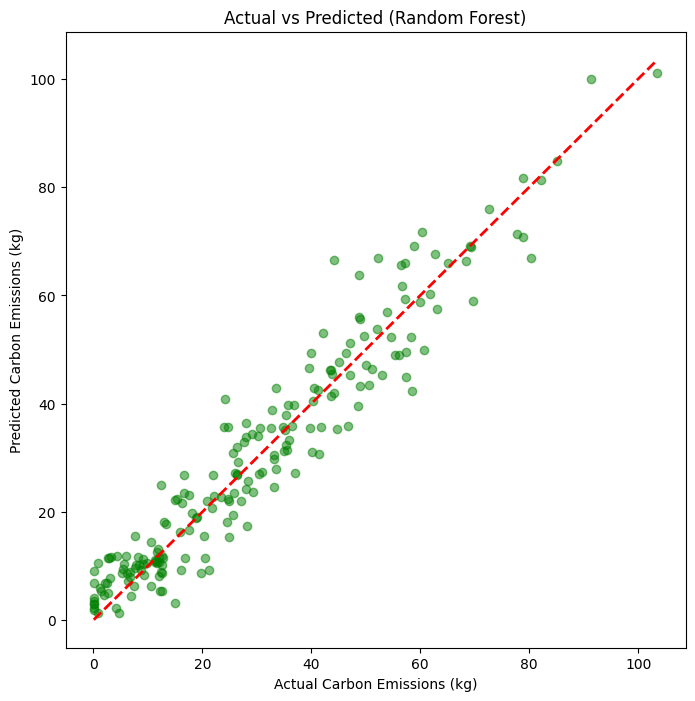

the points are close to the red line which means our predictions are pretty accurate!


In [ ]:
# actual vs predicted scatter plot for best model (Random Forest)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, rf_predictions, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel('Actual Carbon Emissions (kg)')
plt.ylabel('Predicted Carbon Emissions (kg)')
plt.title('Actual vs Predicted (Random Forest)')
plt.show()

print("the points are close to the red line which means our predictions are pretty accurate!")

## 10. Route Recommendation System
This is the main part where we use our model to actually help companies choose greener routes!

The idea is simple - give it different route options and it will tell you which one has lowest emissions.

In [ ]:
# function to predict emissions for a route
# this took me a while to figure out lol

def predict_emissions(distance, cargo_weight, fuel_type, weather, traffic):
    """
    Predicts carbon emissions for a given route.

    Parameters:
    - distance: distance in km
    - cargo_weight: weight in kg
    - fuel_type: 'diesel', 'petrol', 'electric', or 'hybrid'
    - weather: 'clear', 'rain', 'snow', or 'fog'
    - traffic: 'low', 'medium', or 'high'

    Returns: predicted emissions in kg
    """

    # encode the categorical variables (same way as before)
    fuel_encoded = label_encoders['fuel_type'].transform([fuel_type])[0]
    weather_encoded = label_encoders['weather_condition'].transform([weather])[0]
    traffic_encoded = label_encoders['traffic_level'].transform([traffic])[0]

    # create the feature array
    weight_distance_ratio = cargo_weight / distance

    features = np.array([[distance, cargo_weight, fuel_encoded, weather_encoded,
                          traffic_encoded, weight_distance_ratio]])

    # scale the features
    features_scaled = scaler.transform(features)

    # predict using our best model (random forest)
    prediction = rf_model.predict(features_scaled)[0]

    return round(prediction, 2)

print("Function created! lets test it...")

Function created! lets test it...


In [ ]:
# testing with a sample route
test_emission = predict_emissions(
    distance=150,
    cargo_weight=2000,
    fuel_type='diesel',
    weather='clear',
    traffic='medium'
)
print(f"Predicted emissions for sample route: {test_emission} kg CO2")
print("nice it works!")

Predicted emissions for sample route: 25.23 kg CO2
nice it works!


### Example: Comparing Different Route Options
Lets say a company needs to deliver 2000kg cargo from City A to City B. They have 3 route options:

In [ ]:
# Route comparison example
print("="*60)
print("        ROUTE COMPARISON FOR DELIVERY")
print("        Cargo: 2000 kg | Weather: Clear")
print("="*60)
print()

# Route 1: Highway - longer distance, low traffic
route1 = predict_emissions(200, 2000, 'diesel', 'clear', 'low')
print(f"Route 1 (Highway): 200km, diesel, low traffic")
print(f"         Predicted Emissions: {route1} kg CO2")
print()

# Route 2: City route - shorter but high traffic
route2 = predict_emissions(150, 2000, 'diesel', 'clear', 'high')
print(f"Route 2 (City): 150km, diesel, high traffic")
print(f"         Predicted Emissions: {route2} kg CO2")
print()

# Route 3: Highway with electric vehicle
route3 = predict_emissions(200, 2000, 'electric', 'clear', 'low')
print(f"Route 3 (Highway + EV): 200km, electric, low traffic")
print(f"         Predicted Emissions: {route3} kg CO2")
print()

# finding the best route
routes = {'Route 1 (Highway)': route1, 'Route 2 (City)': route2, 'Route 3 (Highway + EV)': route3}
best_route = min(routes, key=routes.get)

print("="*60)
print(f"✅ RECOMMENDATION: {best_route}")
print(f"   This saves {max(routes.values()) - min(routes.values()):.2f} kg CO2 compared to worst option!")
print("="*60)

        ROUTE COMPARISON FOR DELIVERY
        Cargo: 2000 kg | Weather: Clear

Route 1 (Highway): 200km, diesel, low traffic
         Predicted Emissions: 36.02 kg CO2

Route 2 (City): 150km, diesel, high traffic
         Predicted Emissions: 25.72 kg CO2

Route 3 (Highway + EV): 200km, electric, low traffic
         Predicted Emissions: 5.03 kg CO2

✅ RECOMMENDATION: Route 3 (Highway + EV)
   This saves 30.99 kg CO2 compared to worst option!


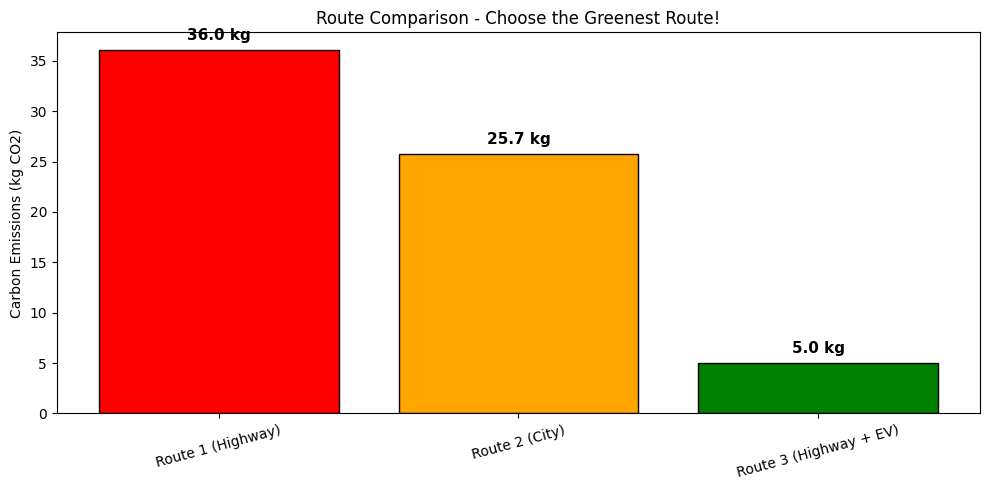

green = best choice, red = worst choice


In [ ]:
# visualizing the route comparison
plt.figure(figsize=(10, 5))
route_names = list(routes.keys())
route_emissions = list(routes.values())

colors = ['red' if x == max(route_emissions) else 'green' if x == min(route_emissions) else 'orange'
          for x in route_emissions]

bars = plt.bar(route_names, route_emissions, color=colors, edgecolor='black')

for bar, val in zip(bars, route_emissions):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.1f} kg', ha='center', fontsize=11, fontweight='bold')

plt.ylabel('Carbon Emissions (kg CO2)')
plt.title('Route Comparison - Choose the Greenest Route!')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print("green = best choice, red = worst choice")

## 11. Conclusion

### What we did:
1. Created a synthetic dataset with 1000 delivery routes
2. Explored the data and made some cool visualizations
3. Preprocessed the data (encoding, scaling)
4. Built 3 ML models: Linear Regression, Decision Tree, and Random Forest
5. Compared all models and found that **Random Forest** works best
6. Created a route recommendation system to help companies choose greener routes

### Features Used:
- **Distance (km)** - route length
- **Cargo Weight (kg)** - how heavy the load is
- **Fuel Type** - diesel, petrol, electric, hybrid
- **Weather Condition** - clear, rain, snow, fog
- **Traffic Level** - low, medium, high

### Key Findings:
- **Fuel Type** and **Distance** are the most important factors affecting emissions
- **Electric vehicles** produce way less emissions than diesel/petrol
- **High traffic** increases emissions a lot (because of idling)
- Random Forest model achieved the best R2 score

### Future Improvements (if i had more time):
- Use real data instead of synthetic data
- Try other models like XGBoost or Neural Networks
- Add more features like vehicle type, speed, road conditions
- Build a web app for the recommendation system

---
**Thanks for reading!** 🌱